In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env.portfolio_env import PortfolioEnv
from models.rl_agent import train_rl_agent, evaluate_agent
from features.features_builder import build_rl_features
from stable_baselines3 import PPO

In [31]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Step 1 : Build the features for the RL agent

### We take the prices of our assets, its returns and the outputs of our previous researches (markowitz weights, HMM regimes, ML predicted regimes) and then add some technical features like vol, momentum

In [32]:
split_date = '2023-01-01'

In [33]:
returns, features = build_rl_features(start_date='2018-01-01',end_date='2025-01-01',tech_feat=True)

features_train = features.loc[:split_date]
returns_train = returns.loc[features_train.index]

features_test = features.loc[split_date:]
returns_test = returns.loc[features_test.index]

/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/RL_Portfolio_Project/data/data.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed
/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:38:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Step 2 : Define the environment and train the model (PPO : on-policy algo)

In [34]:
env_train = PortfolioEnv(features_train, returns_train)

In [35]:
train = False

In [36]:
if train : 
    model = train_rl_agent(env_train, timesteps=100_000, verbose=1)
    model.save("ppo_portfolio_agent.zip")
else : 
    model = PPO.load("ppo_portfolio_agent.zip")


# Step 3 : Evaluate the agent once trained

In [37]:
env_test = PortfolioEnv(features_test, returns_test)
history, infos = evaluate_agent(model, env_test)


# Step 4 : Look at the results

In [38]:
infos_df = pd.DataFrame(infos)
infos_df

,portfolio_value,weights,portfolio_return,step
0,0.969595,"[0.36455908, 0.0, 0.117578894, 0.0, 0.0, 0.517...",-0.030405,1
1,0.993347,"[0.29103765, 0.1200438, 0.29103765, 0.0, 0.291...",0.024497,2
2,0.985079,"[0.22891359, 0.0, 0.222168, 0.14088084, 0.1791...",-0.008323,3
3,1.005436,"[0.34720802, 0.0, 0.0, 0.0, 0.0, 0.65279204]",0.020665,4
4,0.993992,"[0.36768654, 0.10090913, 0.5314043, 0.0, 0.0, ...",-0.011382,5
...,...,...,...,...
495,2.190723,"[0.0, 0.3272528, 0.43124786, 0.0, 0.24149935, ...",-0.000989,496
496,2.191785,"[0.0, 0.0, 0.0, 0.5, 0.0, 0.5]",0.000485,497
497,2.269406,"[0.123330235, 0.0, 0.4383349, 0.0, 0.4383349, ...",0.035415,498
498,2.255448,"[0.27793872, 0.0, 0.36103067, 0.0, 0.36103067,...",-0.006151,499


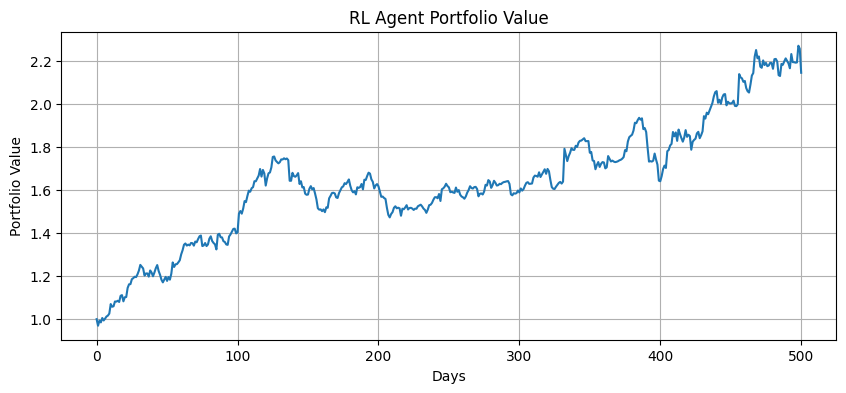

In [39]:
plt.figure(figsize=(10, 4))
plt.plot(history)
plt.title("RL Agent Portfolio Value")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


If the result are not realistic, the reasons could be :
- look ahead bias : using price_t and return_t
- using the same data for training and evaluating
- no constraints
- no transaction costs, ...
- maybe try a different objective, which penalizes big vol (sharpe like objective)
- using all data for Markowitz (including future)

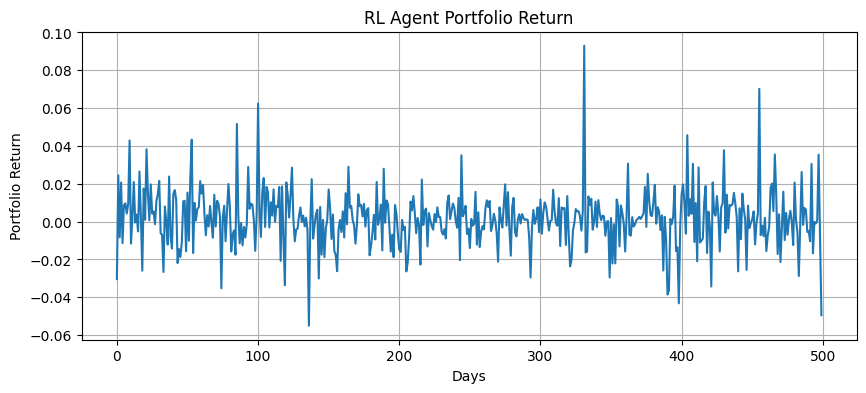

In [40]:
plt.figure(figsize=(10, 4))
plt.plot(infos_df['portfolio_return'])
plt.title("RL Agent Portfolio Return")
plt.xlabel("Days")
plt.ylabel("Portfolio Return")
plt.grid(True)
plt.show()

Allocation over time

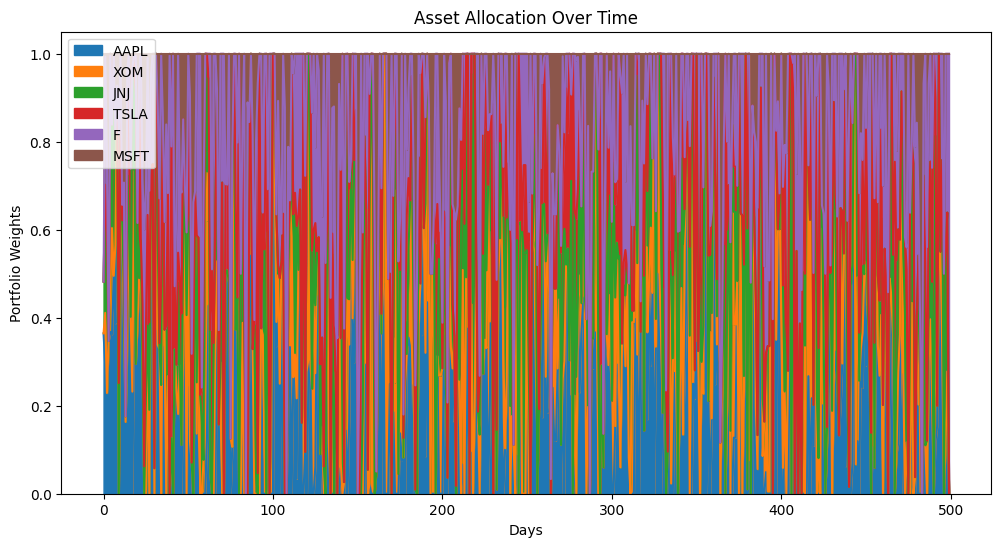

In [41]:
weights_df = pd.DataFrame([info['weights'] for info in infos])
weights_df.columns = ['AAPL', 'XOM', 'JNJ', 'TSLA', 'F', 'MSFT']
weights_df.plot.area(figsize=(12, 6))
plt.title("Asset Allocation Over Time")
plt.ylabel("Portfolio Weights")
plt.xlabel("Days")
plt.legend(loc='upper left')


alignement with market regimes

In [42]:
# Assuming features_df has hmm_0, hmm_1, hmm_2
hmm_regimes = features_test[[col for col in features_test.columns if col.startswith("hmm_")]].idxmax(axis=1)
hmm_regimes = hmm_regimes.str.extract("hmm_(\d+)").astype(int) 
hmm_regimes = hmm_regimes[0].values
hmm_regimes = pd.Series(hmm_regimes, index=returns_test.index, name="hmm_regime")

/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_56875/1089902522.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if hmm_regimes[i] != hmm_regimes[i - 1]:


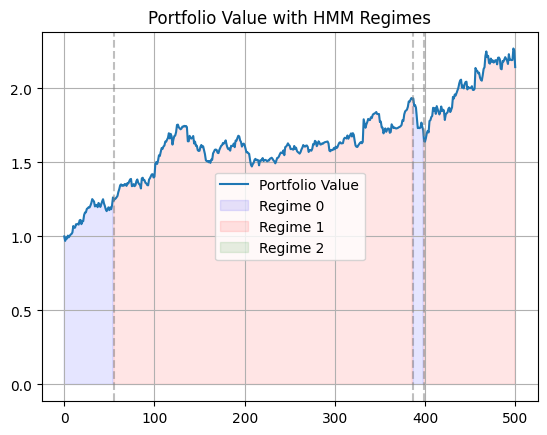

In [43]:
plt.plot(history, label="Portfolio Value")

plt.fill_between(range(len(hmm_regimes)), 0, history, where=hmm_regimes==0, color='blue', alpha=0.1, label='Regime 0')
plt.fill_between(range(len(hmm_regimes)), 0, history, where=hmm_regimes==1, color='red', alpha=0.1, label='Regime 1')
plt.fill_between(range(len(hmm_regimes)), 0, history, where=hmm_regimes==2, color='green', alpha=0.1, label='Regime 2')

for i in range(1, len(hmm_regimes)):
    if hmm_regimes[i] != hmm_regimes[i - 1]:
        plt.axvline(x=i, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.title("Portfolio Value with HMM Regimes")
plt.grid(True)
plt.show()

## Now, we look at the average weights returned by the RL agent, compared to the regimes, to see if the agent adapts its strategy to the given regime input 

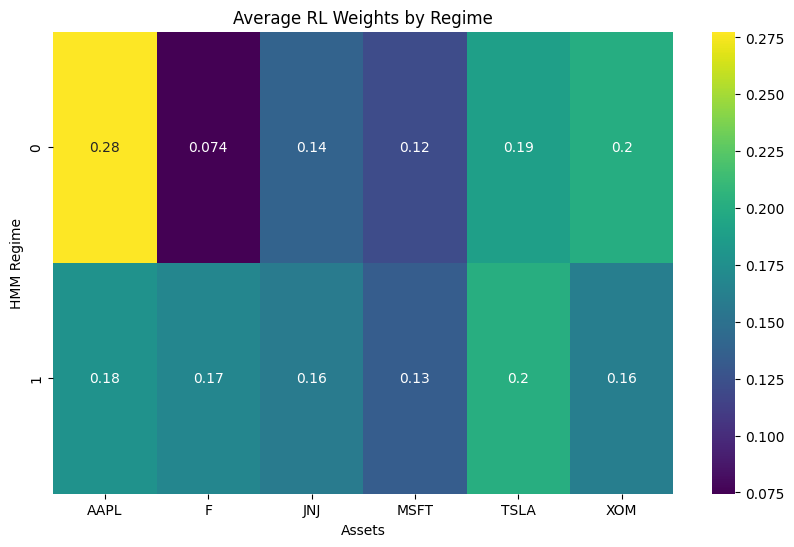

In [44]:
infos_len = len(infos)
aligned_index = returns_test.index[:infos_len]

weights_df = pd.DataFrame([info['weights'] for info in infos], index=aligned_index)
weights_df.columns = returns_test.columns

aligned_regimes = hmm_regimes.loc[weights_df.index]

mean_weights_by_regime = weights_df.groupby(aligned_regimes).mean()

plt.figure(figsize=(10, 6))
sns.heatmap(mean_weights_by_regime, annot=True, cmap='viridis')
plt.title("Average RL Weights by Regime")
plt.ylabel("HMM Regime")
plt.xlabel("Assets")
plt.show()


# Step 5 : Compare our policy vs Markowitz

In [45]:
from features.markowitz import get_markowitz_weights
from data.data import get_data
import numpy as np

In [46]:
def simulate_portfolio(returns_df, weights_df, initial_cash=1.0):
    portfolio_value = initial_cash
    values = []

    for i in range(len(returns_df)):
        daily_return = np.dot(weights_df.iloc[i], returns_df.iloc[i])
        portfolio_value *= (1 + daily_return)
        values.append(portfolio_value)

    return values


In [47]:
tickers = ['AAPL', 'XOM', 'JNJ', 'TSLA', 'F', 'MSFT']
start_date = '2023-01-01'
end_date = '2025-01-01'

prices = get_data(tickers, start_date, end_date)

markowitz_weights = get_markowitz_weights(prices)

aligned_index = markowitz_weights.index.intersection(returns_test.index)

returns_test_aligned = returns_test.loc[aligned_index]
markowitz_weights_test = markowitz_weights.loc[aligned_index]

markowitz_value = simulate_portfolio(returns_test_aligned, markowitz_weights_test)


/Users/julesarzel/Documents/M2ISF/Portfolio_Opti/Portfolio_Opti/RL_Portfolio_Project/data/data.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed


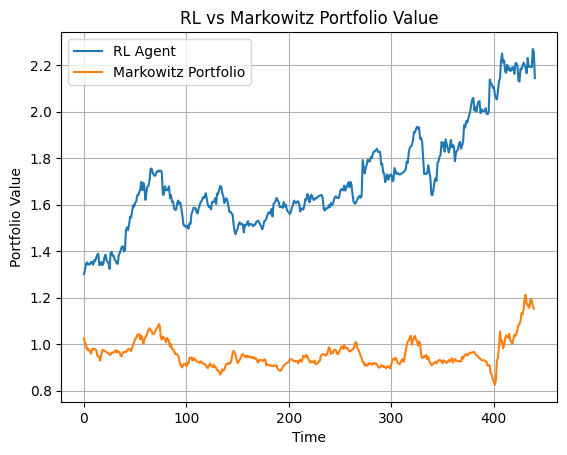

In [48]:
plt.plot(history[60:], label='RL Agent')
plt.plot(markowitz_value, label='Markowitz Portfolio')
plt.title('RL vs Markowitz Portfolio Value')
plt.ylabel('Portfolio Value')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.show()


## Performance evaluation

In [49]:
def compute_sharpe_ratio(portfolio_values, risk_free_rate=0.0):
    returns = pd.Series(portfolio_values).pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252  
    sharpe = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_annualized = sharpe * np.sqrt(252)
    return sharpe_annualized

In [50]:
results = pd.DataFrame({
    "Strategy": ["RL Agent", "Markowitz"],
    "Sharpe Ratio": [compute_sharpe_ratio(history), compute_sharpe_ratio(markowitz_value)]
})

print(results.to_string(index=False, float_format="%.3f"))


 Strategy  Sharpe Ratio
 RL Agent         1.749
Markowitz         0.423


# 6. Next Improvements

This notebook presents a first version of the reinforcement learning-based portfolio allocation strategy. Several extensions and improvements are currently being considered:

- **Transaction costs**: Introduce proportional transaction costs to better reflect real-world trading constraints and penalize excessive rebalancing.
- **Alternative data**: Incorporate additional inputs such as volatility indices (VIX), macroeconomic indicators, or market sentiment to improve regime detection and allocation decisions.
- **Validation and evaluation**:
  - Implement walk-forward or rolling-window validation.
  - Evaluate the model using additional metrics (e.g. max drawdown, Sortino ratio, turnover) beyond the Sharpe ratio.
- **Feature engineering**: Explore dimensionality reduction (e.g. PCA) or feature selection techniques to improve stability.
- **Compare RL models**: Benchmark PPO against other RL algorithms in the same setting.
